# Prepare working db
- Load data
- df cleaning
- Create label for recruting status
- Export full dataset to sqlite

In [1]:
import json, os
import numpy as np
import pandas as pd
import sqlite3
import shutil
import matplotlib.pyplot as plt
# import nltk

## Load json file with parsed information

In [2]:
# paths
path_to_json_file = os.path.abspath('../data/json/')

### json file
# json_file = '/all_parsed_data_json' #name json file  
json_file = '/sample_json' #sample json file for testing  

file = '{}{}.json'.format(path_to_json_file, json_file)

In [3]:
# load json file
df = pd.read_json(file)

In [4]:
# Display full dataframe
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.width', 1000)

In [5]:
# Check data
df.shape

(5984, 24)

In [ ]:
# Remove all_files folder
path_to_all_files = os.path.abspath('../data/all_trials//')

def remove_extra_folders(folder):
    try:
        shutil.rmtree(folder)
        print("\nunzip folder deleted")
    except IOError as e:
        print(e)
        pass

In [ ]:
%time remove_extra_folders(path_to_all_files)

## Format dataset

In [6]:
# function to change column type

def data_types(dataframe, cols = [], to_type = ''):
    for col in cols:
        dataframe[col] = df[col].astype(to_type)
        

In [7]:
columns_dates = ['study_first_submitted', 'last_update_submitted', 'verification_date']
data_types(df, columns_dates, 'datetime64')

In [8]:
# Extract year 
df['year_submitted'] = df['study_first_submitted'].dt.year
df['year_last_updated'] = df['last_update_submitted'].dt.year
df['verification_year'] = df['verification_date'].dt.year

In [9]:
# Remove unnecesary columns
# df.drop(columns_dates, axis = 1, inplace=True)

In [10]:
# columns_to_drop = ['study_first_posted', 'last_update_posted', 'verification_date']
# df.drop(columns_to_drop, axis = 1, inplace=True)

In [11]:
# Remove /n in all df
df = df.replace(r'\n',' ', regex=True)

In [12]:
# Create new column for all text
df['all_text'] = df['source'] + ' ' + df['brief_title'] + ' ' + df['condition'] + ' ' + df['condition_browse/mesh_term'] + ' '+ df['intervention_browse/mesh_term'] + ' '+ df['detailed_description/textblock'] + ' ' + df['brief_summary/textblock']

# All_text in lowercase
df['all_text'] = df['all_text'].str.lower()

# remove extra whitespace
df.all_text = df.all_text.replace('\s+', ' ', regex=True)


In [13]:
# Remove extra white space in summary
df['brief_summary/textblock'] = df['brief_summary/textblock'].replace('\s+', ' ', regex=True)
df['brief_summary/textblock'][0]

' Primary objective: To evaluate the safety and tolerability of single and multiple ascending doses of PB1023 administered as a subcutaneous (SC) injection in adult subjects with T2DM. Secondary objectives: 1. To characterize the pharmacokinetic profile of PB1023 after single and multiple ascending doses of PB1023. 2. To assess the pharmacodynamic response of various single and multiple doses of PB1023 (daily fasting plasma glucose, and serial glucose, c-peptide and insulin levels in response to a liquid Mixed Meal Tolerance Test (MMTT). '

In [14]:
# # add url columns
url_string = 'https://clinicaltrials.gov/ct2/show/'
df['url'] = url_string + df['nct_id'].astype(str)

## Recruiting status
- Create criteria for filtering recruiting status
- Create new column with labels

In [15]:
''' Recruiting status 
0 - Not recruting, including all records not updated 
1 - Possibily recruiting. Define time range for category 
2 - Recruiting

'''

df.overall_status.unique()

array(['Completed', 'Recruiting', 'Terminated', 'Not yet recruiting',
       'Active, not recruiting', 'Withdrawn', 'Unknown status',
       'Enrolling by invitation', 'Withheld', 'Suspended', 'Available',
       'No longer available', 'Approved for marketing',
       'Temporarily not available'], dtype=object)

In [16]:
# Selecting open trials
# https://clinicaltrials.gov/ct2/help/glossary/recruitment-status

recruiting = df[(df['overall_status'] == "Recruiting") | \
                (df['overall_status'] == "Not yet recruiting") | \
                (df['overall_status'] == "Available for expanded access")]

# Check recruiting studies
print('Total of trials classified as recruiting: {}'.format(len(recruiting)))

print('Trials not verified in the last two years 2017-2019: {}'.\
      format(len(recruiting[recruiting['verification_year'] < 2017])))

Total of trials classified as recruiting: 1257
Trials not verified in the last two years 2017-2019: 638


In [17]:
recruiting.overall_status.unique()

array(['Recruiting', 'Not yet recruiting'], dtype=object)

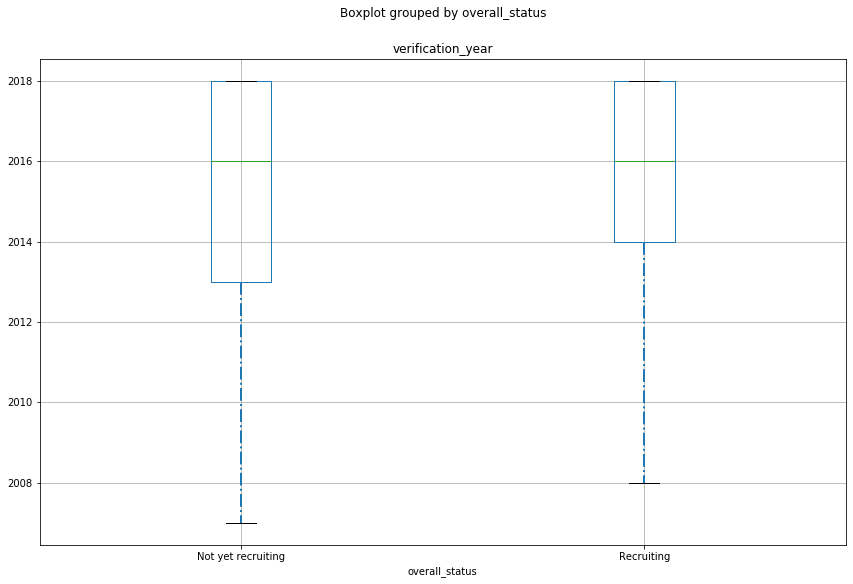

In [18]:
# Trials by verification date

'''Unknown: A study with a status of Recruiting, Not yet recruiting, 
or Active, not recruiting and whose status has not been verified within the past 2 years. 

** Studies with an Unknown recruitment status are considered open studies or closed studies, 
depending on their last known recruitment status**

'''
recruiting.boxplot(column='verification_year', by='overall_status', \
                   figsize=(14,9), showfliers=False, meanline=True,\
                   whiskerprops = dict(linestyle='-.', linewidth=2))

# recruiting.boxplot(column='year_last_updated')
# recruiting['verification_year'].plot(kind='box', figsize=(10,7))
# recruiting['year_last_updated'].plot(kind='box', figsize=(10,7))

In [19]:
# Create new column with recruiting status based on verification date


In [20]:
# Function to assign recruiting labels
options = [
    (df['verification_year'] < 2017),
    (df['verification_year'] > 2017) & (df['overall_status'] == "Recruiting") | \
                (df['overall_status'] == "Not yet recruiting") | \
                (df['overall_status'] == "Available for expanded access")]
labels = [0, 1]
df['recruiting_labels'] = np.select(options, labels, default=0)

df['recruiting_labels'].value_counts()


0    5525
1     459
Name: recruiting_labels, dtype: int64

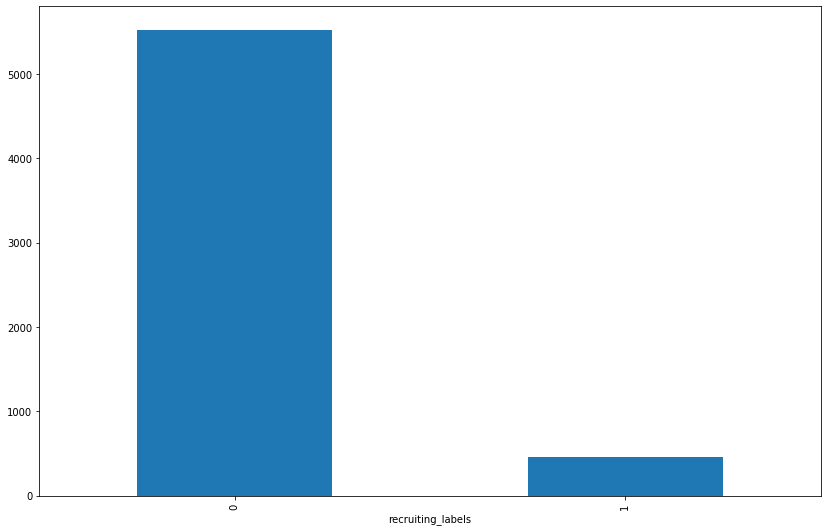

In [21]:
df.groupby('recruiting_labels').size().plot(kind='bar', figsize=(14,9))

# Create sqlite db

In [25]:
# Create folder

path_to_working_datasets = os.path.abspath('../data/working_data')

try: 
    os.mkdir(path_to_working_datasets)
except:
    pass
    print('Error')

Error


In [26]:
# Create and connect to db
conn = sqlite3.connect('../data/working_data/working-database.db')
conn


In [27]:
# upload df to database: define schema
%time df.to_sql('all_trials', con=conn)

CPU times: user 143 ms, sys: 58 ms, total: 201 ms
Wall time: 226 ms


In [28]:
# get list of indexes
pd.read_sql_query("PRAGMA index_list(all_trials);", conn)

,seq,name,unique,origin,partial
0,0,ix_all_trials_index,0,c,0


In [29]:
# test 1. Filter by condition
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

CPU times: user 25 ms, sys: 11 ms, total: 35.9 ms
Wall time: 35.2 ms


,index,nct_id,study_first_submitted,source,brief_title,overall_status,verification_date,study_type,study_first_posted,last_update_submitted,...,sponsors/lead_sponsor/agency_class,study_design_info/allocation,study_design_info/intervention_model,study_design_info/primary_purpose,year_submitted,year_last_updated,verification_year,all_text,url,recruiting_labels
0,1014,NCT00933309,2009-07-03 00:00:00,M.D. Anderson Cancer Center,The Impact of Obesity and Obesity Treatments o...,Completed,2012-12-01 00:00:00,Interventional,"July 7, 2009",2016-02-17 00:00:00,...,Other,Randomized,Single Group Assignment,Treatment,2009,2016,2012.0,m.d. anderson cancer center the impact of obes...,https://clinicaltrials.gov/ct2/show/NCT00933309,0
1,1016,NCT01003951,2009-10-28 00:00:00,Memorial Sloan Kettering Cancer Center,Acupuncture for the Treatment of Chronic Lymph...,Completed,2011-07-01 00:00:00,Interventional,"October 29, 2009",2012-08-15 00:00:00,...,Other,None,Single Group Assignment,Treatment,2009,2012,2011.0,memorial sloan kettering cancer center acupunc...,https://clinicaltrials.gov/ct2/show/NCT01003951,0
2,1020,NCT01417286,2011-08-02 00:00:00,"Rutgers, The State University of New Jersey",Accelerated Radiation Therapy After Surgery in...,"Active, not recruiting",2012-01-01 00:00:00,Interventional,"August 16, 2011",2018-08-08 00:00:00,...,Other,None,Single Group Assignment,Treatment,2011,2018,2012.0,"rutgers, the state university of new jersey ac...",https://clinicaltrials.gov/ct2/show/NCT01417286,0
3,1022,NCT02370264,2015-02-17 00:00:00,University of Southern California,Questionnaires in Identifying Upper Extremity ...,Terminated,2008-05-01 00:00:00,Interventional,"February 24, 2015",2017-04-11 00:00:00,...,Other,None,Single Group Assignment,Supportive Care,2015,2017,2008.0,university of southern california questionnair...,https://clinicaltrials.gov/ct2/show/NCT02370264,0
4,107,NCT00322348,2006-05-03 00:00:00,AstraZeneca,Study of Zoladex Given Every 12 Weeks Versus G...,Completed,2010-12-01 00:00:00,Interventional,"May 5, 2006",2010-12-22 00:00:00,...,Industry,Randomized,Parallel Assignment,Treatment,2006,2010,2010.0,astrazeneca study of zoladex given every 12 we...,https://clinicaltrials.gov/ct2/show/NCT00322348,0


In [ ]:
# test 2. Filter by recruiting status = 1
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE recruiting_labels == 1;", conn)
len(search_query)

In [ ]:
# Create index on all_text column
c = conn.cursor()
%time c.execute("CREATE INDEX idx1 ON all_trials(all_text)")
conn.commit()

In [ ]:
# get list of indexes
pd.read_sql_query("PRAGMA index_list(all_trials);", conn)

In [ ]:
# test new query
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

In [ ]:
%time new_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn).head()
new_query.head()

In [ ]:
'''
Optimize performance
https://medium.com/@JasonWyatt/squeezing-performance-from-sqlite-indexes-indexes-c4e175f3c346
'''

_____

## Test queries speed

In [ ]:
# Check data types
# pd.read_sql_query("PRAGMA table_info(all_trials);", conn)

In [ ]:
# Time query with WHERE condition
%time search_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
search_query.head()

In [ ]:
# Time query with WHERE condition, return nct_id
%time filtered_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
filtered_query.head()

In [ ]:
# drop original index
%time c.execute("DROP INDEX ix_all_trials_index")
conn.commit()


## Test queries after creating index

In [ ]:
# Time query with WHERE condition after creating index
%time optimized_query = pd.read_sql_query("SELECT * from all_trials WHERE all_text LIKE '%breast cancer%';", conn)
optimized_query.head()

In [ ]:
# Return only nct_id
%time new_query = pd.read_sql_query("SELECT nct_id from all_trials WHERE all_text LIKE '%breast cancer%';", conn).head()
new_query.head()


## Pending: Test search pattern to optimize queries, return results

## Preprocess dataset
- Tokenize, Lemmatize / Stem
- Remove stopwords

In [ ]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

# porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

In [ ]:
# Stemming
# def stem_sentences(text):
#     tokens = text.split()
#     stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
#     return ' '.join(stemmed_tokens)

# df['stems'] = df['all_text'].apply(stem_sentences)

In [ ]:
# Lemmatizing
def lemm_sentences(text):
    tokens = text.split()
    lemm_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemm_tokens)

df['lemmas'] = df['all_text'].apply(lemm_sentences)

In [ ]:
# Remove stop words [not needed with countvectorizer]
# stop_words = stopwords.words('english')
# df['tokens'] = df['lemmas'].apply(lambda x: [item for item in x.split() if item not in stop_words])

In [ ]:
df.lemmas[0:5]

## Bags of words

In [ ]:
# Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

In [ ]:
pat_numbers = lambda x: re.sub(r'(\d)+', '', x.lower())

cv = CountVectorizer(stop_words='english',
                     preprocessor = pat_numbers,
                     max_features = 1800,
                     lowercase = True,
                     max_df = 0.8,
                     ngram_range = (1, 3))

In [ ]:
docs = list(df['lemmas'])

X = cv.fit_transform(docs)

In [ ]:
len(cv.vocabulary_)

In [ ]:
word_counts = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

In [ ]:
# add nct_id to word_counts df
nct_id = df['nct_id']

df_word_counts = pd.merge(nct_id, word_counts, left_index=True, right_index=True)

In [ ]:
df_word_counts.head()

_______

In [ ]:
# Check all dataframes in space
%who DataFrame

In [ ]:
# upload count_vectorizer to database
# sqlite limit = 2000
df_word_counts.to_sql('word_counts', con=conn)

In [ ]:
df_counts = pd.read_sql_query("SELECT * from word_counts;", conn)
df_counts.head()

In [ ]:
# List databases
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

In [ ]:
conn.close()

--------

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
transformer = TfidfTransformer()
tweights = transformer.fit_transform(X)
tweights

In [ ]:
# turn weights data into a dataframe
tf = pd.DataFrame(tweights.toarray(), columns=cv.get_feature_names())

In [ ]:
# Top terms by average tf-idf weight
weights = np.asarray(tweights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cv.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

In [ ]:
# Create new dataframe with nct-id and merge wth tf by index
pd.set_option('display.max_columns', None) 

df_tf = df['nct_id']
df_tf.head()

In [ ]:
df_tf = pd.merge(df_tf, tf, left_index=True, right_index=True)

In [ ]:
df_tf.head()

## Test merged dataframes with tf-idf results

In [ ]:
# import random

# def compare_results():
#     row = random.randint(0,3000)
#     df_tf.drop('nct_id', axis = 1)
#     print('Random row: {}'.format(row))
#     return df_tf.loc[row], tf.loc[row]

In [ ]:
# compare_results()

## Calculate correlation between docs

In [ ]:
# calculate similary
similarity = tweights * tweights.T

In [ ]:
# Save all data in a dataframe
df_docs_similarity = pd.DataFrame(similarity.toarray())

<b>To-do: Give a NTC-ID record, find similar documents
& return dataframe with results</b>

In [ ]:
# Find more similar documents of a given record

def find_similar_docs(record, rate):
    trials_id = []
    treshold = rate
    similar_index = df_docs_similarity.iloc[record][df_docs_similarity.iloc[record] > treshold].index
    
    for i in similar_index.values:
        trials_id.append(i)
        
    print('{} similar trials with treshold {}'.format(len(trials_id), treshold))
    return df.iloc[trials_id]


In [ ]:
find_similar_docs(0, 0.50)